# FFR120 Simulation of Complex Systems - Crowd Disasters
**Group** - Team Butterflies

**Members**:
- Artur ..
- Maria
- Nina
- Ruiqi
- Rundong .,

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import math
import dataclasses
import json

import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.patches as patches

from sim_state import SimState, history_to_dataframe
from constants import SimConstants, constants_to_json
from forces import get_forces

In [2]:
class AnimationSettings:
    display_size = 8, 8   # Size of display in inches
    dpi = 100    # Pixels per inch
    framerate = 15
    exit_color = "#00FF00"
    wall_color = "000000"
    
    @classmethod
    def get_person_size(cls, sconst):
        return (
            cls.dpi * cls.display_size[0] * sconst.individual_radius / (sconst.right_outer - sconst.left_outer) 
        )
    
    
seed = 69420
rng = np.random.default_rng(seed)
gif_writer = anim.PillowWriter(fps=AnimationSettings.framerate)


## Simulation


In [3]:
def get_overlap_individuals_with_rectangle(positions, rectangle, individual_radius):
    bbox_botleft = positions - individual_radius
    bbox_topright = positions + individual_radius
    
    rect_botleft = rectangle[0, :]
    rect_topright = rectangle[2, :]
    
    i_rect_overlap = np.where(
        (bbox_botleft[:, 0] > rect_botleft[0]) &
        (bbox_topright[:, 0] < rect_topright[0]) &
        (bbox_botleft[:, 1] > rect_botleft[1]) &
        (bbox_topright[:, 1] < rect_topright[1])
    )
    
    return i_rect_overlap


def get_touching_individuals_with_rectangle(sconst, positions, rectangle):    
    bbox_botleft = positions - sconst.individual_radius
    bbox_topright = positions + sconst.individual_radius
        
    rect_botleft = rectangle[0, :]
    rect_topright = rectangle[2, :]
    
    b_left = bbox_botleft[:, 0]
    b_right = bbox_topright[:, 0]
    b_bot = bbox_botleft[:, 1]
    b_top = bbox_topright[:, 1]
    
    r_left = rect_botleft[0]
    r_right = rect_topright[0]
    r_bot = rect_botleft[1]
    r_top = rect_topright[1]
    
    i_rect_overlap = np.where(
        (
            ((b_right > r_left) & (b_right < r_right)) |
            ((b_left > r_left) & (b_left < r_right))
        ) &
        (
            ((b_top > r_bot) & (b_top < r_top)) |
            ((b_bot > r_bot) & (b_bot < r_top))
        )
    )
    
    return i_rect_overlap
    

In [4]:
def get_initial_positions(sconst):
    radius = sconst.individual_radius
    diameter = 2 * radius
            
    n_x = int(sconst.length // diameter)
    n_y = int(sconst.width // diameter)
    choices = []
    
    for i_y in range(n_y):
        for i_x in range(n_x):
            x = sconst.left_inner + radius + i_x * diameter
            y = sconst.bot_inner + radius + i_y * diameter
            choices.append((x, y))
            
    rng.shuffle(choices)
    
    positions = np.array(choices[:sconst.n_individuals], dtype=float)
    return positions

In [5]:
def run_simulation(sconst) -> list[SimState]:     
    state = SimState(
        positions=get_initial_positions(sconst),
        velocities=np.zeros(shape=(sconst.n_individuals, 2)),
        forces=np.zeros(shape=(sconst.n_individuals, 2)),
        pressures=np.zeros(shape=(sconst.n_individuals, 1)),
        person_states=np.zeros(shape=(sconst.n_individuals,))
    )
    
    history = [state.copy()]
    
    for time_step in range(sconst.n_time_steps):
        if (time_step+1) % 100 == 0:
            print(f"Time step: {time_step}/{sconst.n_time_steps-1}")
            
        active = state.person_states == sconst.s_living
        
        state.positions[active, :] = state.positions[active] + state.velocities[active] * sconst.time_inc
        env_forces, social_forces = get_forces(sconst, state)

        state.forces = env_forces + social_forces
        state.pressures = np.linalg.norm(env_forces, axis=1)
            
        state.velocities[active] = (
            state.velocities[active] +
            state.forces[active] * sconst.force_scalar
        )
        
        i_exiting = get_overlap_individuals_with_rectangle(state.positions, sconst.exits[0], sconst.individual_radius)
        state.person_states[i_exiting] = sconst.s_exited
        
        i_dead = state.pressures > sconst.lethal_pressure
        state.person_states[i_dead] = sconst.s_dead
                
        history.append(state.copy())

    return history

## Animation

In [6]:
def get_time_step(i_frame: int, frame_rate: int, time_inc: float) -> int:
    """Get the time step corresponding to actual time passed of simulation.

    Example:
        50 fps -> 0.02s per frame
        0.01 time_inc -> 2 time steps per frame
        3 frames -> 6 time_steps

    Args:
        i_frame: The frame currently being rendered:
        frame_rate: Number of frames rendered per second.
        time_inc: The time passed between time steps.
    """
    return int((i_frame / frame_rate) / time_inc)


def get_rectangle_pos_and_size_for_patch(rect) -> tuple[np.ndarray, float, float]:
    """Extract position, width, and height from the rectangle.
    
    Each rectangle is defined by the points (topleft, topright, botright, botleft).
    A patch is defined by the (botleft, width, height).
    """
    
    pos = rect[0, :]
    w = rect[2, 0]-rect[0, 0]
    h = rect[2, 1]-rect[0, 1]
    return pos, w, h 


def render_state(i_frame, fig, sconst, history, screen_live, screen_dead, screen_exit):
    i_time = get_time_step(i_frame, AnimationSettings.framerate, sconst.time_inc)
    
    if i_time > len(history):
        return screen_live, screen_dead, screen_exit
    
    state = history[i_time]
    
    pos_dead = state.positions[state.person_states == sconst.s_dead]
    screen_dead.set_data(pos_dead[:, 0], pos_dead[:, 1])
    
    #pos_exit = state.positions[state.person_states == sconst.s_exited]
    #screen_exit.set_data(pos_exit[:, 0], pos_exit[:, 1])
    
    pos_live = state.positions[state.person_states == sconst.s_living]
    screen_live.set_data(pos_live[:, 0], pos_live[:, 1])
        
    return screen_live, screen_dead, screen_exit


def render_simulation(sconst, history: list[SimState]) -> None:
    fig = plt.figure(
        figsize=AnimationSettings.display_size,
        dpi=AnimationSettings.dpi
    )
    ax = fig.gca()

    person_size = AnimationSettings.get_person_size(sconst)
    screen_live, = ax.plot([], [], 'bo', ms=person_size)
    screen_dead, = ax.plot([], [], 'ro', ms=person_size)
    screen_exit, = ax.plot([], [], 'go', ms=person_size)
    
    for exit in sconst.exits:
        exit = patches.Rectangle(
            *get_rectangle_pos_and_size_for_patch(exit),
            color=AnimationSettings.exit_color
        )
        ax.add_patch(exit)
        
    for wall in sconst.walls:
        wall = patches.Rectangle(
            *get_rectangle_pos_and_size_for_patch(wall),
            color=AnimationSettings.wall_color
        )
        ax.add_patch(wall)
    
    ax.set_xlim(sconst.left_outer, sconst.right_outer)
    ax.set_ylim(sconst.bot_outer, sconst.top_outer)
        
    animation = anim.FuncAnimation(
        fig=fig, func=render_state, frames=sconst.simulation_time*AnimationSettings.framerate,
        fargs=(fig, sconst, history, screen_live, screen_dead, screen_exit),
        blit=True, interval=int(1000/AnimationSettings.framerate)
    )
    return animation
    

## Execution

In [7]:
def execute_suite(n_individuals, width, v_max, save_animation=True, save_history=True, save_constants=True):    
    sconst = SimConstants(width=width, n_individuals=n_individuals, v_max=v_max)

    history = run_simulation(sconst)
    animation = render_simulation(sconst, history)
    
    name = f"n={n_individuals},w={width},v={v_max}"

    if save_animation:
        path = f"./gifs/anim_{name}.gif"
        animation.save(path, writer=gif_writer)
        print(f"Animation successfully saved to {path}")

    if save_history:
        path = f'./data/hist_{name}.csv'
        df = history_to_dataframe(sconst, history)
        df.to_csv(f'./data/data_{name}.csv', index=False)
        print(f"History successfully saved to {path}")

        
    if save_constants:
        path = f'./data/const_{name}.json'
        const = constants_to_json(sconst)
        with open(path, 'w') as f:
            f.write(json.dumps(const, ensure_ascii=False))
            
        print(f"Constants successfully saved to {path}")

        
    return history, animation, sconst


Time step: 99/999
Time step: 199/999
Time step: 299/999
Time step: 399/999
Time step: 499/999
Time step: 599/999
Time step: 699/999
Time step: 799/999
Time step: 899/999
Time step: 999/999


<IPython.core.display.Javascript object>


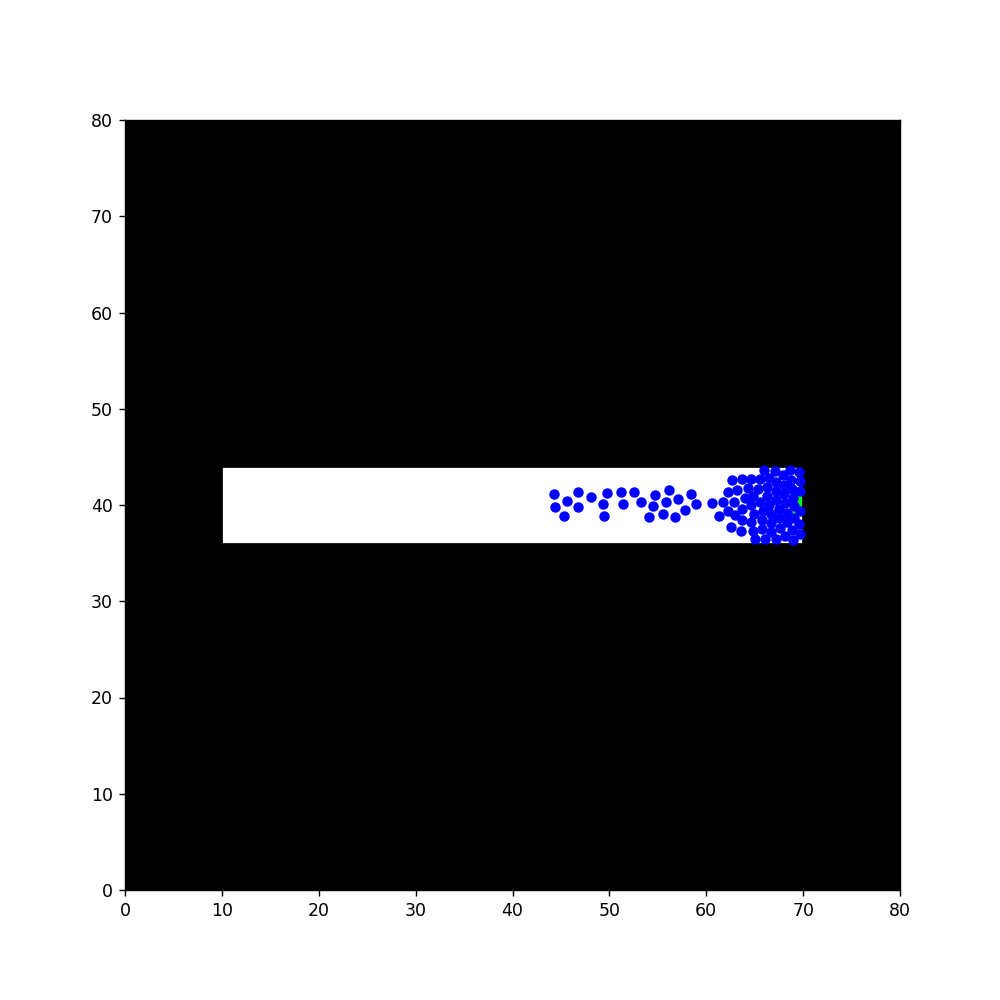

Animation successfully saved to ./gifs/anim_n=100,w=8,v=10.gif
History successfully saved to ./data/hist_n=100,w=8,v=10.csv
Constants successfully saved to ./data/const_n=100,w=8,v=10.json


In [8]:
h, a, c = execute_suite(100, 8, 10);
a